<a href="https://colab.research.google.com/github/BRIAN12682/Automation-Projects/blob/main/NLPMalaria4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip install --upgrade accelerate torch
!pip install datasets
clear_output()

In [2]:
from IPython.display import clear_output
!pip install transformers[torch]
clear_output()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, UnidentifiedImageError
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class MalariaDataset(Dataset):
    def __init__(self, annotations_dir, images_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.images_dir = images_dir
        self.transform = transform
        self.data = self._load_data()

    def _load_data(self):
        annotations = []
        for class_folder in ['Positive', 'Negative']:
            class_path = os.path.join(self.images_dir, class_folder)
            for img_file in os.listdir(class_path):
                if img_file.endswith('.jpg'):
                    filename = img_file
                    xml_file = os.path.splitext(filename)[0] + ".xml"
                    xml_path = os.path.join(self.annotations_dir, xml_file)
                    try:
                        tree = ET.parse(xml_path)
                        root = tree.getroot()

                        boxes = []
                        for obj in root.findall('object'):
                            bbox = obj.find('bndbox')
                            if bbox is not None:
                                xmin = float(bbox.find('xmin').text)
                                ymin = float(bbox.find('ymin').text)
                                xmax = float(bbox.find('xmax').text)
                                ymax = float(bbox.find('ymax').text)
                                boxes.append([xmin, ymin, xmax, ymax])
                        annotations.append({'filename': os.path.join(class_folder, filename), 'boxes': boxes})
                    except ET.ParseError as e:
                        print(f"Error parsing {xml_file}: {e}")
                    except FileNotFoundError:
                        # For negative class, there might not be an xml file
                        if class_folder == 'negative':
                            annotations.append({'filename': os.path.join(class_folder, filename), 'boxes': []})
        return annotations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.images_dir, item['filename'])
        try:
            image = Image.open(image_path).convert('RGB')
        except (UnidentifiedImageError, FileNotFoundError) as e:
            print(f"Error loading image {image_path}: {e}")
            return self.__getitem__((idx + 1) % len(self.data))  # Try the next item
        if self.transform:
            image = self.transform(image)
        boxes = item['boxes']
        num_pathogens = len(boxes)
        if num_pathogens == 0:
            caption = "This image shows no pathogens and is not infected."
        elif num_pathogens > 5:
            caption = f"This image shows approximately {num_pathogens} pathogens and is severely infected.Immediate action needs to be taken in the instance that the plasmodium is P.Falciparum"
        else:
            caption = f"This image shows approximately {num_pathogens} pathogens and is moderately infected. My current capabilities can not classify the observed characteristics for the different types of the of the Malaria plasmodium."
        return image, caption

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Paths to datasets and annotations
train_images_dir = '/content/drive/MyDrive/DATASETS/MalariaPI/train'
val_images_dir = '/content/drive/MyDrive/DATASETS/MalariaPI/val'
annotations_dir = '/content/drive/MyDrive/DATASETS/MalariaPI/annotation'

# Load datasets
train_dataset = MalariaDataset(annotations_dir, train_images_dir, transform=transform)
val_dataset = MalariaDataset(annotations_dir, val_images_dir, transform=transform)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [5]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 2162
Number of validation samples: 541


In [24]:
import torch

# Clear cached memory
torch.cuda.empty_cache()

# Confirm GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to GPU
base_model.to(device)
clear_output()

In [14]:
from transformers import VisionEncoderDecoderModel, ViTModel, GPT2Tokenizer, ViTImageProcessor
import torch
import torch.nn as nn

class CustomViTModel(ViTModel):
    def __init__(self, config):
        super().__init__(config)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU()

    def forward(self, pixel_values, **kwargs):
        # Preprocess the image with convolutional layers
        x = self.conv1(pixel_values)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)

        # Ignore any kwargs not relevant for ViTModel
        vit_kwargs = {k: v for k, v in kwargs.items() if k in ['head_mask', 'output_attentions', 'output_hidden_states', 'return_dict']}

        # Pass the processed output to the original ViTModel
        return super().forward(pixel_values=x, **vit_kwargs)





# Initialize the tokenizer and processor
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set padding token

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Initialize the base VisionEncoderDecoderModel
base_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Replace the encoder with the custom one
custom_encoder = CustomViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
base_model.encoder = custom_encoder

base_model.config.decoder_start_token_id = tokenizer.bos_token_id
base_model.config.pad_token_id = tokenizer.eos_token_id

# Enable gradient checkpointing for more memory efficient training
base_model.encoder.gradient_checkpointing_enable()
base_model.decoder.gradient_checkpointing_enable()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)


Some weights of CustomViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['conv1.bias', 'conv1.weight', 'conv2.bias', 'conv2.weight', 'conv3.bias', 'conv3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): CustomViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Li

In [8]:
!pip show accelerate

Name: accelerate
Version: 0.31.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [21]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.1 MB/s eta 0:00:00


In [22]:
import torch
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import sacrebleu  # Make sure to install sacrebleu

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,

    eval_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    output_dir="./results",
    logging_steps=10,
    save_steps=10,
    eval_steps=10,
    num_train_epochs=1,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
)

# Custom compute metrics function
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions.argmax(-1)
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    bleu_score = sacrebleu.corpus_bleu(pred_str, [label_str]).score
    return {"bleu": bleu_score}

# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
train_result = trainer.train()

# Save training results
train_metrics = train_result.metrics
trainer.log_metrics("train", train_metrics)
trainer.save_metrics("train", train_metrics)
trainer.save_state()

# Evaluate the model
eval_results = trainer.evaluate()

# Save evaluation results
trainer.log_metrics("eval", eval_results)
trainer.save_metrics("eval", eval_results)

# Save the model and tokenizer
base_model.save_pretrained("/content/drive/MyDrive/vitgpt_model")
tokenizer.save_pretrained("/content/drive/MyDrive/vitgpt_model")

# Save the validation BLEU score
with open("/content/drive/MyDrive/validation_bleu.txt", "w") as f:
    f.write(f"Validation BLEU Score: {eval_results['eval_bleu']}\n")


Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Directory to save the model and tokenizer
output_dir ="/content/drive/MyDrive/vitgpt_model"

# Save the model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

# Save the processor (ViT image processor)
processor.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")


Model and tokenizer saved to /content/drive/MyDrive/vitgpt_model


In [ ]:

# Save the model and tokenizer
model.save_pretrained("/content/drive/MyDrive/vitgpt_model")
tokenizer.save_pretrained("/content/drive/MyDrive/vitgpt_model")

# # Save the validation accuracy
# with open("/content/drive/MyDrive/validation_accuracy.txt", "w") as f:
#     f.write(f"Validation Accuracy: {validation_accuracy}\n")


('/content/drive/MyDrive/vitgpt_model/tokenizer_config.json',
 '/content/drive/MyDrive/vitgpt_model/special_tokens_map.json',
 '/content/drive/MyDrive/vitgpt_model/vocab.json',
 '/content/drive/MyDrive/vitgpt_model/merges.txt',
 '/content/drive/MyDrive/vitgpt_model/added_tokens.json')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


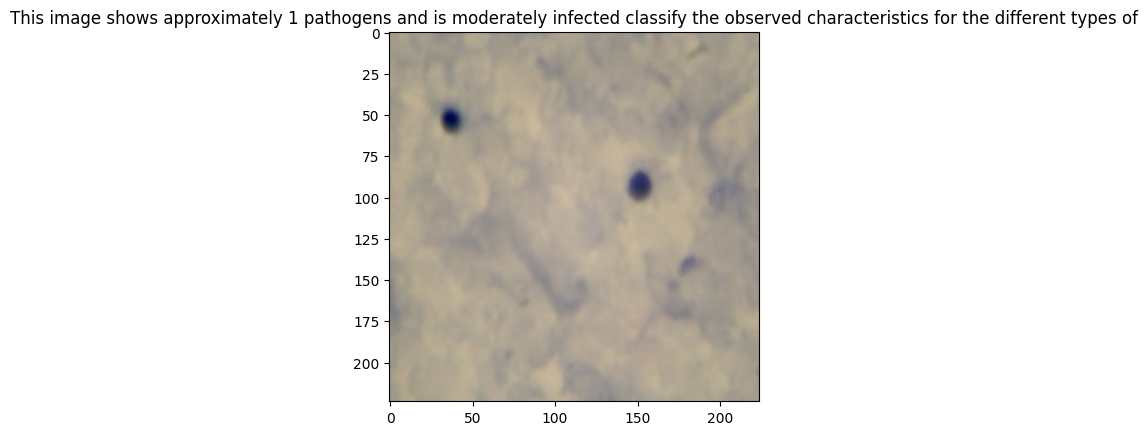

In [ ]:
import matplotlib.pyplot as plt

def predict_and_visualize(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    pixel_values = processor(images=[image], return_tensors="pt", do_rescale=False).pixel_values.to(device)
    output_ids = model.generate(pixel_values)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    plt.imshow(image)
    plt.title(caption)
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Negative/plasmodium-0001.jpg'
predict_and_visualize(test_image_path)


Caption: This image shows no pathogens and is not infected.Immediate action needs to be taken in the


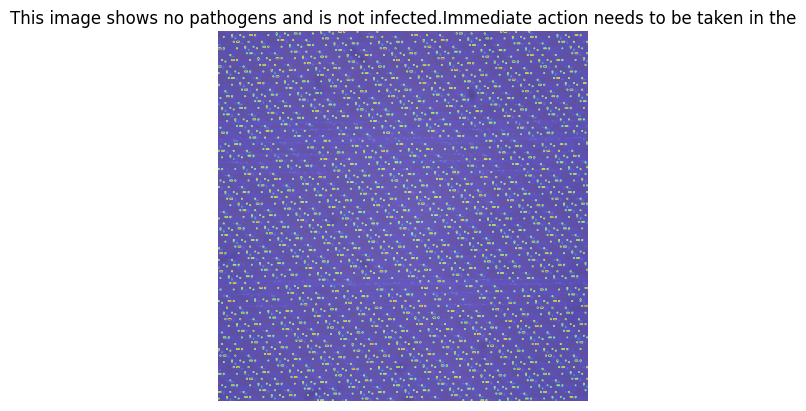

In [ ]:
import numpy as np# Add this function after defining your model and other necessary components
def visualize_attention(image_path, model, tokenizer, processor):
    # Load and process the imageV
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Get the hidden states and attentions from the encoder
    model.eval()
    with torch.no_grad():
        encoder_outputs = model.encoder(**inputs, output_attentions=True, return_dict=True)

    # Decode the generated caption
    pixel_values = inputs["pixel_values"]
    generated_ids = model.generate(pixel_values)
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Caption: {caption}")

    # Extract the attention weights
    encoder_attentions = encoder_outputs.attentions
    last_layer_attentions = encoder_attentions[-1]

    # Average the attention weights over all heads
    attn_weights = last_layer_attentions.mean(dim=1).squeeze().cpu().numpy()

    # Normalize the attention map
    attn_map = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min())

    # Resize the attention map to match the image size
    attn_map = np.resize(attn_map, (image.size[1], image.size[0]))

    # Overlay the attention map on the original image
    plt.imshow(image)
    plt.imshow(attn_map, cmap="jet", alpha=0.5)  # Adjust the alpha value to control transparency
    plt.axis("off")
    plt.title(caption)
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/DATASETS/MalariaPI/train/Negative/plasmodium-0028.jpg'
visualize_attention(test_image_path, model, tokenizer, processor)


Caption: This image shows approximately 9 pathogens and is severely infected.Immediate action needs to be taken in


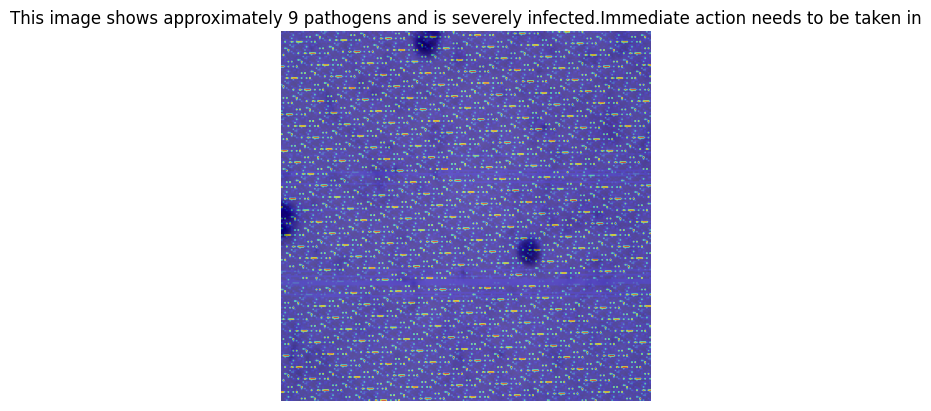

In [ ]:
import numpy as np# Add this function after defining your model and other necessary components
def visualize_attention(image_path, model, tokenizer, processor):
    # Load and process the imageV
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Get the hidden states and attentions from the encoder
    model.eval()
    with torch.no_grad():
        encoder_outputs = model.encoder(**inputs, output_attentions=True, return_dict=True)

    # Decode the generated caption
    pixel_values = inputs["pixel_values"]
    generated_ids = model.generate(pixel_values)
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Caption: {caption}")

    # Extract the attention weights
    encoder_attentions = encoder_outputs.attentions
    last_layer_attentions = encoder_attentions[-1]

    # Average the attention weights over all heads
    attn_weights = last_layer_attentions.mean(dim=1).squeeze().cpu().numpy()

    # Normalize the attention map
    attn_map = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min())

    # Resize the attention map to match the image size
    attn_map = np.resize(attn_map, (image.size[1], image.size[0]))

    # Overlay the attention map on the original image
    plt.imshow(image)
    plt.imshow(attn_map, cmap="jet", alpha=0.5)  # Adjust the alpha value to control transparency
    plt.axis("off")
    plt.title(caption)
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/DATASETS/MalariaPI/train/Positive/plasmodium-0007.jpg'
visualize_attention(test_image_path, model, tokenizer, processor)


In [ ]:
pip install rouge_score

In [ ]:
from transformers import VisionEncoderDecoderModel, GPT2Tokenizer, ViTImageProcessor
import torch

# Directory where the model, tokenizer, and processor are saved
output_dir = "/content/drive/MyDrive/vitgpt_model"


# Load the model, tokenizer, and processor
model = VisionEncoderDecoderModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
processor = ViTImageProcessor.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [ ]:
from IPython.display import clear_output
!pip install datasets
!pip install rouge_score
clear_output()

In [ ]:
from datasets import load_metric
import numpy as np

# Define evaluation metrics
bleu = load_metric("bleu")
rouge = load_metric("rouge")
meteor = load_metric("meteor")
# cider = load_metric("cider")

def compute_metrics(predictions, references):
    pred_str = [{"caption": p} for p in predictions]
    ref_str = [[{"caption": r}] for r in references]

    bleu_score = bleu.compute(predictions=pred_str, references=ref_str)
    rouge_score = rouge.compute(predictions=pred_str, references=ref_str)
    meteor_score = meteor.compute(predictions=pred_str, references=ref_str)
    # cider_score = cider.compute(predictions=pred_str, references=ref_str)

    return {
        "bleu": bleu_score["bleu"],
        "rouge": rouge_score["rougeL"].mid.fmeasure,
        "meteor": meteor_score["meteor"],
        # "cider": cider_score["CIDEr"]
    }


<ipython-input-1-e1019a8869de>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu = load_metric("bleu")


The repository for bleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for meteor contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/meteor.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
val_dataset = MalariaDataset(annotations_dir, val_images_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [ ]:
!pip install datasets rouge_score nltk git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-_v9u2bzs
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-_v9u2bzs
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=510b17af41e2275f10a2f1bf5115bbcc4db7db0380b5c17a81dc62f851b90b97
  Stored in directory: /tmp/pip-ephem-wheel-cache-299wv_ze/wheels/43/54/73/3e2c6d4ace7657958cde52ac6fd47b342cd4aae5a7aa4fcbf9
Successfully built pycocoevalcap


In [ ]:
from transformers import VisionEncoderDecoderModel, GPT2Tokenizer, ViTImageProcessor
import torch

# Directory where the model, tokenizer, and processor are saved
output_dir = "/content/drive/MyDrive/vitgpt_model"


# Load the model, tokenizer, and processor
model = VisionEncoderDecoderModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
processor = ViTImageProcessor.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from IPython.display import clear_output
!pip install datasets
!pip install rouge_score
clear_output()

In [ ]:
from datasets import load_metric
import numpy as np

# Define evaluation metrics
bleu = load_metric("bleu")
rouge = load_metric("rouge")
meteor = load_metric("meteor")
# cider = load_metric("cider")

def compute_metrics(predictions, references):
    pred_str = [{"caption": p} for p in predictions]
    ref_str = [[{"caption": r}] for r in references]

    bleu_score = bleu.compute(predictions=pred_str, references=ref_str)
    rouge_score = rouge.compute(predictions=pred_str, references=ref_str)
    meteor_score = meteor.compute(predictions=pred_str, references=ref_str)
    # cider_score = cider.compute(predictions=pred_str, references=ref_str)

    return {
        "bleu": bleu_score["bleu"],
        "rouge": rouge_score["rougeL"].mid.fmeasure,
        "meteor": meteor_score["meteor"],
        # "cider": cider_score["CIDEr"]
    }

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:

val_dataset = MalariaDataset(annotations_dir, val_images_dir, transform=transform) # Assuming MalariaDataset and required variables are defined
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

from tqdm import tqdm
from datasets import load_metric

# Load the appropriate metric for text generation, for example, ROUGE
# rouge = load_metric("rouge")
from datasets import load_metric
import numpy as np

# Define evaluation metrics
bleu = load_metric("bleu")
rouge = load_metric("rouge")
meteor = load_metric("meteor")
# cider = load_metric("cider")

def compute_metrics(predictions, references):
    pred_str = [{"caption": p} for p in predictions]
    ref_str = [[{"caption": r}] for r in references]

    bleu_score = bleu.compute(predictions=pred_str, references=ref_str) # Calculate bleu score
    rouge_score = rouge.compute(predictions=pred_str, references=ref_str)
    meteor_score = meteor.compute(predictions=pred_str, references=ref_str) # Calculate meteor score
    # cider_score = cider.compute(predictions=pred_str, references=ref_str)

    return {
        "bleu": bleu_score["bleu"],
        "rouge": rouge_score["rougeL"].mid.fmeasure,
        "meteor": meteor_score["meteor"],
        # "cider": cider_score["CIDEr"]
    }

def evaluate_model(model, dataloader, tokenizer):
    model.eval()
    predictions = []
    references = []

    for batch in tqdm(dataloader):
        pixel_values = batch[0].to(device)
        captions = batch[1]

        with torch.no_grad():
            output_ids = model.generate(pixel_values, max_length=30, num_beams=4)
        pred_str = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        predictions.extend(pred_str)
        references.extend(captions)

    metrics = compute_metrics(predictions, references)
    return metrics

# Compute metrics using the updated compute_metrics function
metrics = evaluate_model(model, val_dataloader, tokenizer)
print(metrics)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 68/68 [02:12<00:00,  1.95s/it]


{'bleu': 0.0, 'rouge': 0.7726539488253714, 'meteor': 0.7638465077834995}


In [ ]:
!pip install opencv-python-headless
clear_output()

In [ ]:
print(model)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

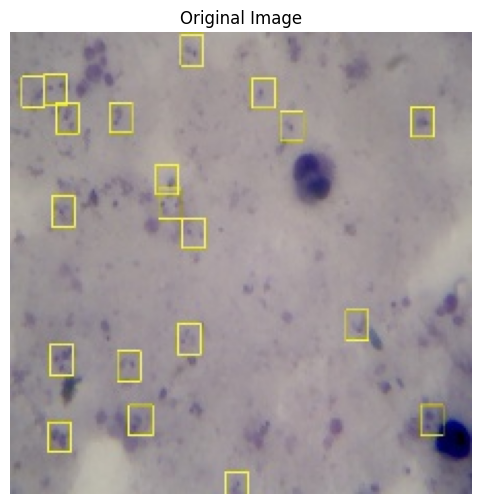

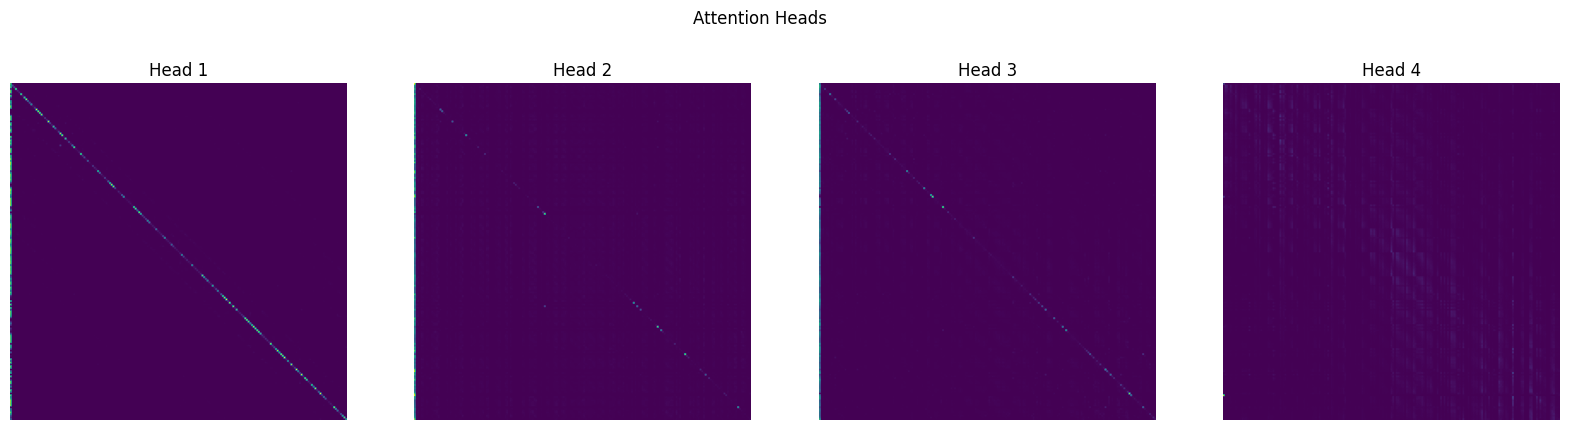

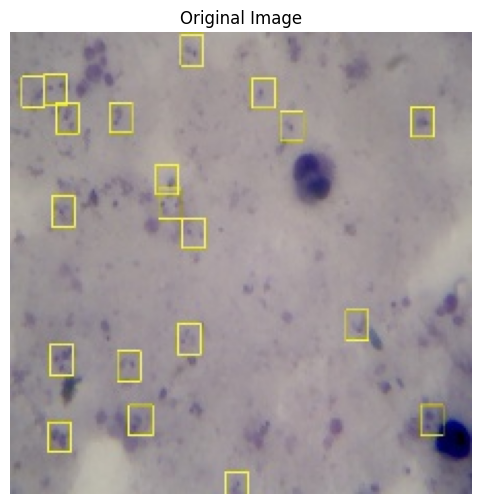

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import VisionEncoderDecoderModel, GPT2Tokenizer, ViTImageProcessor

# Directory where the model, tokenizer, and processor are saved
output_dir = "/content/drive/MyDrive/vitgpt_model"

# Load the model, tokenizer, and processor
model = VisionEncoderDecoderModel.from_pretrained(output_dir, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
processor = ViTImageProcessor.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Path to the dataset directory
dir_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive'
files = os.listdir(dir_path)

# Limit to the first 5 images
files = files[:1]

def show_attention_maps(image_path, attention_map, num_heads=4):
    """
    Display the original image along with its attention maps.

    Args:
    - image_path (str): Path to the input image.
    - attention_map (Tensor): Attention map for the selected layer.
    - num_heads (int): Number of attention heads to display. Default is 4.
    """
    # Load and display the original image
    original_image = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    # Display attention maps for the selected heads
    attention = attention_map[0, :num_heads].cpu().detach().numpy()
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 5))
    fig.suptitle('Attention Heads')

    for j in range(num_heads):
        axs[j].imshow(attention[j], cmap='viridis')
        axs[j].set_title(f'Head {j+1}')
        axs[j].axis('off')

    plt.show()

for file in files:
    # Full path to the image file
    img_path = os.path.join(dir_path, file)

    # Load and preprocess the image
    image = Image.open(img_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Prepare the decoder input
    decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id]]).to(device)

    # Get model outputs including attentions
    outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids, output_attentions=True)
    encoder_attentions = outputs.encoder_attentions

    # Visualize the attention maps from the first ViTLayer's attention layer
    show_attention_maps(img_path, encoder_attentions[0])

    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import VisionEncoderDecoderModel, GPT2Tokenizer, ViTImageProcessor

# Directory where the model, tokenizer, and processor are saved
output_dir = "/content/drive/MyDrive/vitgpt_model"

# Load the model, tokenizer, and processor
model = VisionEncoderDecoderModel.from_pretrained(output_dir, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
processor = ViTImageProcessor.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Path to the dataset directory
dir_path = '/content/drive/MyDrive/DATASETS/MalariaPI/images'
files = os.listdir(dir_path)

# Limit to the first 5 images
files = files[:1]

def show_attention_maps(image_path, attention_map, num_heads=4):
    """
    Display the original image along with its attention maps.

    Args:
    - image_path (str): Path to the input image.
    - attention_map (Tensor): Attention map for the selected layer.
    - num_heads (int): Number of attention heads to display. Default is 4.
    """
    # Load and display the original image
    original_image = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    # Display attention maps for the selected heads
    attention = attention_map[0, :num_heads].cpu().detach().numpy()
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 5))
    fig.suptitle('Attention Heads')

    for j in range(num_heads):
        axs[j].imshow(attention[j], cmap='viridis')
        axs[j].set_title(f'Head {j+1}')
        axs[j].axis('off')

    plt.show()

for file in files:
    # Full path to the image file
    img_path = os.path.join(dir_path, file)

    # Load and preprocess the image
    image = Image.open(img_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Prepare the decoder input
    decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id]]).to(device)

    # Get model outputs including attentions
    outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids, output_attentions=True)
    encoder_attentions = outputs.encoder_attentions

    # Visualize the attention maps from the last ViTLayer's attention layer
    show_attention_maps(img_path, encoder_attentions[-1])

    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()


Caption: This image shows approximately 9 pathogens and is severely infected.Immediate action needs to be taken in


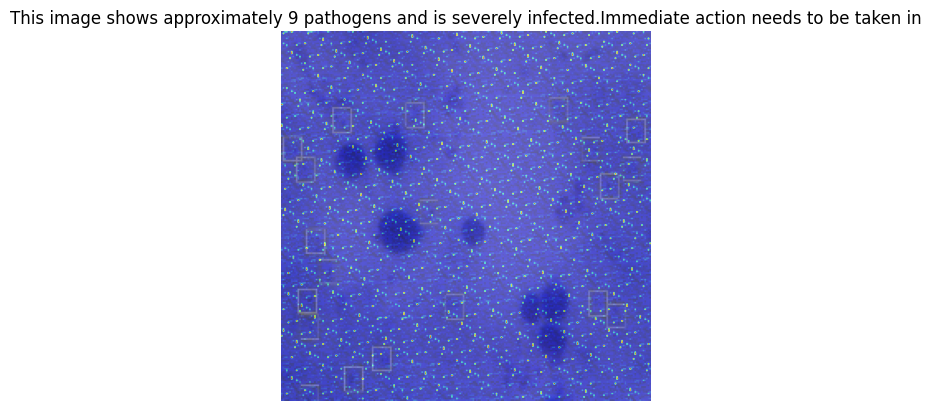

In [ ]:
import numpy as np# Add this function after defining your model and other necessary components
def visualize_attention(image_path, model, tokenizer, processor):
    # Load and process the imageV
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Get the hidden states and attentions from the encoder
    model.eval()
    with torch.no_grad():
        encoder_outputs = model.encoder(**inputs, output_attentions=True, return_dict=True)

    # Decode the generated caption
    pixel_values = inputs["pixel_values"]
    generated_ids = model.generate(pixel_values)
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Caption: {caption}")

    # Extract the attention weights
    encoder_attentions = encoder_outputs.attentions
    last_layer_attentions = encoder_attentions[-1]

    # Average the attention weights over all heads
    attn_weights = last_layer_attentions.mean(dim=1).squeeze().cpu().numpy()

    # Normalize the attention map
    attn_map = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min())

    # Resize the attention map to match the image size
    attn_map = np.resize(attn_map, (image.size[1], image.size[0]))

    # Overlay the attention map on the original image
    plt.imshow(image)
    plt.imshow(attn_map, cmap="jet", alpha=0.5)  # Adjust the alpha value to control transparency
    plt.axis("off")
    plt.title(caption)
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-0000.jpg'
visualize_attention(test_image_path, model, tokenizer, processor)


In [ ]:
import numpy as np
# Add this function after defining your model and other necessary components
import matplotlib.pyplot as plt

def visualize_attention(image_path, model, tokenizer, processor):
    # Load and process the imageV
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Get the hidden states and attentions from the encoder
    model.eval()
    with torch.no_grad():
        encoder_outputs = model.encoder(**inputs, output_attentions=True, return_dict=True)

    # Decode the generated caption
    pixel_values = inputs["pixel_values"]
    generated_ids = model.generate(pixel_values)
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Caption: {caption}")

    # Extract the attention weights
    encoder_attentions = encoder_outputs.attentions
    last_layer_attentions = encoder_attentions[-1]

    # Average the attention weights over all heads
    attn_weights = last_layer_attentions.mean(dim=1).squeeze().cpu().numpy()

    # Normalize the attention map
    attn_map = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min())

    # Resize the attention map to match the image size
    attn_map = np.resize(attn_map, (image.size[1], image.size[0]))

    # Overlay the attention map on the original image
    plt.imshow(image)
    plt.imshow(attn_map, cmap="jet", alpha=0.5)  # Adjust the alpha value to control transparency
    plt.axis("off")
    plt.title(caption)
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/DATASETS/MalariaPI/images/plasmodium-2702.jpg'
visualize_attention(test_image_path, model, tokenizer, processor)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DATASETS/MalariaPI/images/plasmodium-2702.jpg'

Caption: This image shows no pathogens and is not infected.Immediate action needs to be taken in the


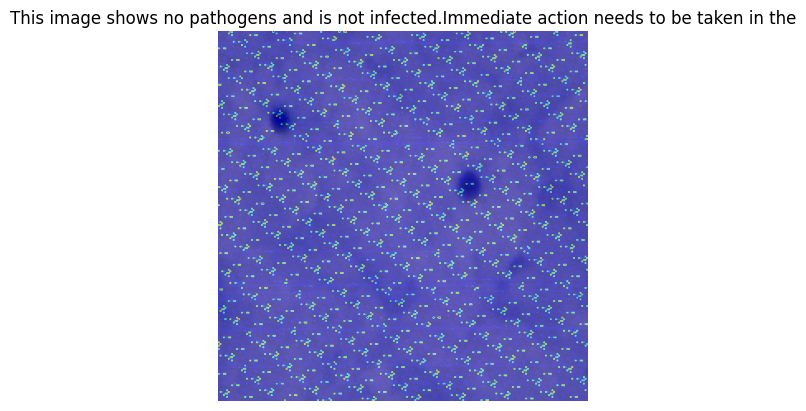

In [ ]:
import numpy as np# Add this function after defining your model and other necessary components
def visualize_attention(image_path, model, tokenizer, processor):
    # Load and process the imageV
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Get the hidden states and attentions from the encoder
    model.eval()
    with torch.no_grad():
        encoder_outputs = model.encoder(**inputs, output_attentions=True, return_dict=True)

    # Decode the generated caption
    pixel_values = inputs["pixel_values"]
    generated_ids = model.generate(pixel_values)
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Caption: {caption}")

    # Extract the attention weights
    encoder_attentions = encoder_outputs.attentions
    last_layer_attentions = encoder_attentions[-1]

    # Average the attention weights over all heads
    attn_weights = last_layer_attentions.mean(dim=1).squeeze().cpu().numpy()

    # Normalize the attention map
    attn_map = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min())

    # Resize the attention map to match the image size
    attn_map = np.resize(attn_map, (image.size[1], image.size[0]))

    # Overlay the attention map on the original image
    plt.imshow(image)
    plt.imshow(attn_map, cmap="jet", alpha=0.5)  # Adjust the alpha value to control transparency
    plt.axis("off")
    plt.title(caption)
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Negative/plasmodium-0001.jpg'
visualize_attention(test_image_path, model, tokenizer, processor)


In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# Load a pre-trained translation model
translation_model_name = "Helsinki-NLP/opus-mt-en-fr"  # English to French
translation_model = MarianMTModel.from_pretrained(translation_model_name)
translation_tokenizer = MarianTokenizer.from_pretrained(translation_model_name)


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
def translate_text(text, translation_model, translation_tokenizer):
    inputs = translation_tokenizer(text, return_tensors="pt", padding=True)
    translated = translation_model.generate(**inputs)
    translated_text = translation_tokenizer.batch_decode(translated, skip_special_tokens=True)
    return translated_text[0]

translated_caption = translate_text(caption, translation_model, translation_tokenizer)
print(f"Translated Caption: {translated_caption}")


Translated Caption: Cette image montre 17 pathogènes et est gravement infectée.


Caption: This image shows approximately 1 pathogens and is moderately infected classify the observed characteristics for the different types of


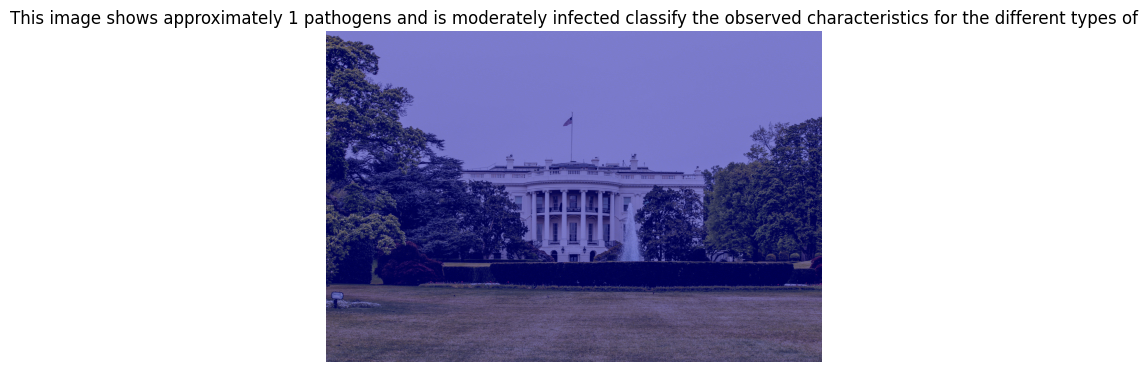

In [ ]:
import numpy as np# Add this function after defining your model and other necessary components
def visualize_attention(image_path, model, tokenizer, processor):
    # Load and process the imageV
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Get the hidden states and attentions from the encoder
    model.eval()
    with torch.no_grad():
        encoder_outputs = model.encoder(**inputs, output_attentions=True, return_dict=True)

    # Decode the generated caption
    pixel_values = inputs["pixel_values"]
    generated_ids = model.generate(pixel_values)
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Caption: {caption}")

    # Extract the attention weights
    encoder_attentions = encoder_outputs.attentions
    last_layer_attentions = encoder_attentions[-1]

    # Average the attention weights over all heads
    attn_weights = last_layer_attentions.mean(dim=1).squeeze().cpu().numpy()

    # Normalize the attention map
    attn_map = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min())

    # Resize the attention map to match the image size
    attn_map = np.resize(attn_map, (image.size[1], image.size[0]))

    # Overlay the attention map on the original image
    plt.imshow(image)
    plt.imshow(attn_map, cmap="jet", alpha=0.5)  # Adjust the alpha value to control transparency
    plt.axis("off")
    plt.title(caption)
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/statehouse.jpg'
visualize_attention(test_image_path, model, tokenizer, processor)


Caption: This image shows approximately 6 pathogens and is severely infected.Immediate action needs to be taken in


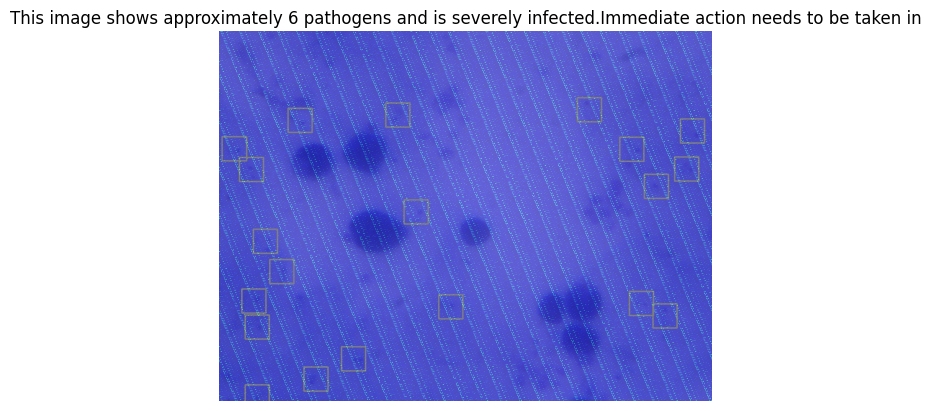

In [ ]:
import numpy as np# Add this function after defining your model and other necessary components
def visualize_attention(image_path, model, tokenizer, processor):
    # Load and process the imageV
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Get the hidden states and attentions from the encoder
    model.eval()
    with torch.no_grad():
        encoder_outputs = model.encoder(**inputs, output_attentions=True, return_dict=True)

    # Decode the generated caption
    pixel_values = inputs["pixel_values"]
    generated_ids = model.generate(pixel_values)
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Caption: {caption}")

    # Extract the attention weights
    encoder_attentions = encoder_outputs.attentions
    last_layer_attentions = encoder_attentions[-1]

    # Average the attention weights over all heads
    attn_weights = last_layer_attentions.mean(dim=1).squeeze().cpu().numpy()

    # Normalize the attention map
    attn_map = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min())

    # Resize the attention map to match the image size
    attn_map = np.resize(attn_map, (image.size[1], image.size[0]))

    # Overlay the attention map on the original image
    plt.imshow(image)
    plt.imshow(attn_map, cmap="jet", alpha=0.5)  # Adjust the alpha value to control transparency
    plt.axis("off")
    plt.title(caption)
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/Organised_Annotated_Folder/Positive/plasmodium-0000.jpg'
visualize_attention(test_image_path, model, tokenizer, processor)


In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# Load a pre-trained translation model for English to Swahili
translation_model_name = "Helsinki-NLP/opus-mt-en-sw"
translation_model = MarianMTModel.from_pretrained(translation_model_name)
translation_tokenizer = MarianTokenizer.from_pretrained(translation_model_name)


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/300M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/821k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2Tokenizer
from PIL import Image

# Load the saved model, tokenizer, and processor
model = VisionEncoderDecoderModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
processor = ViTImageProcessor.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load a pre-trained translation model for English to Swahili
translation_model_name = "Helsinki-NLP/opus-mt-en-sw"
translation_model = MarianMTModel.from_pretrained(translation_model_name)
translation_tokenizer = MarianTokenizer.from_pretrained(translation_model_name)

# Define a function for translating text to Swahili
def translate_text(text, translation_model, translation_tokenizer):
    inputs = translation_tokenizer(text, return_tensors="pt", padding=True)
    translated = translation_model.generate(**inputs)
    translated_text = translation_tokenizer.batch_decode(translated, skip_special_tokens=True)
    return translated_text[0]

# Define a function for generating captions from images
def generate_caption(image_path, model, processor, tokenizer, device):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = model.generate(pixel_values)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption

# Example usage
test_image_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-0000.jpg'
caption = generate_caption(test_image_path, model, processor, tokenizer, device)
print(f"Caption: {caption}")

translated_caption = translate_text(caption, translation_model, translation_tokenizer)
print(f"Translated Caption: {translated_caption}")


Caption: This image shows approximately 9 pathogens and is severely infected.Immediate action needs to be taken in
Translated Caption: Picha hii inaonyesha takriban pathojeni 9 na imeambukizwa vibaya sana.Immediate inahitaji kuchukuliwa


In [ ]:
!pip install onnx onnx-tf tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 46.7 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, GPT2Tokenizer, ViTImageProcessor
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Directory where the model, tokenizer, and processor are saved
output_dir = "/content/drive/MyDrive/vitgpt_model"

# Load the model, tokenizer, and processor
model = VisionEncoderDecoderModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
processor = ViTImageProcessor.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 1: Export the model to ONNX
dummy_input = {
    "pixel_values": torch.randn(1, 3, 224, 224).to(device),  # Example input size for ViT
    "decoder_input_ids": torch.tensor([[tokenizer.bos_token_id]], device=device)
}
onnx_model_path = "/content/drive/MyDrive/vitgpt_model.onnx"
torch.onnx.export(
    model,
    (dummy_input["pixel_values"], dummy_input["decoder_input_ids"]),
    onnx_model_path,
    input_names=["pixel_values", "decoder_input_ids"],
    output_names=["output"],
    dynamic_axes={"pixel_values": {0: "batch_size"}, "decoder_input_ids": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)
print(f"Model exported to {onnx_model_path}")

# Step 2: Convert the ONNX model to TensorFlow
onnx_model = onnx.load(onnx_model_path)
tf_rep = prepare(onnx_model)
tf_model_path = "/content/drive/MyDrive/vitgpt_tf_model"
tf_rep.export_graph(tf_model_path)
print(f"Model exported to {tf_model_path}")

# Step 3: Convert the TensorFlow model to TensorFlow Lite with Select TensorFlow Ops enabled
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow Select ops.
]
tflite_model = converter.convert()
tflite_model_path = "/content/drive/MyDrive/vitgpt_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Model exported to {tflite_model_path}")

# Provide a link to download the TensorFlow Lite model
from IPython.display import FileLink

FileLink(tflite_model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:164: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


Model exported to /content/drive/MyDrive/vitgpt_model.onnx
Model exported to /content/drive/MyDrive/vitgpt_tf_model
Model exported to /content/drive/MyDrive/vitgpt_model.tflite


/content/drive/MyDrive/vitgpt_model.tflite

In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, GPT2Tokenizer, ViTImageProcessor
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Directory where the model, tokenizer, and processor are saved
output_dir = "/content/drive/MyDrive/vitgpt_model"

# Load the model, tokenizer, and processor
model = VisionEncoderDecoderModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
processor = ViTImageProcessor.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 1: Export the model to ONNX
dummy_input = {
    "pixel_values": torch.randn(1, 3, 224, 224).to(device),  # Example input size for ViT
    "decoder_input_ids": torch.tensor([[tokenizer.bos_token_id]], device=device)
}
onnx_model_path = "/content/drive/MyDrive/vitgpt_model.onnx"
torch.onnx.export(
    model,
    (dummy_input["pixel_values"], dummy_input["decoder_input_ids"]),
    onnx_model_path,
    input_names=["pixel_values", "decoder_input_ids"],
    output_names=["output"],
    dynamic_axes={"pixel_values": {0: "batch_size"}, "decoder_input_ids": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)
print(f"Model exported to {onnx_model_path}")

# Step 2: Convert the ONNX model to TensorFlow
onnx_model = onnx.load(onnx_model_path)
tf_rep = prepare(onnx_model)
tf_model_path = "/content/drive/MyDrive/vitgpt_tf_model"
tf_rep.export_graph(tf_model_path)
print(f"Model exported to {tf_model_path}")

# Step 3: Convert the TensorFlow model to TensorFlow Lite with Quantization
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow Select ops.
]

# Apply quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
tflite_model_path = "/content/drive/MyDrive/vitgpt_model_quantized.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Quantized model exported to {tflite_model_path}")

# Provide a link to download the TensorFlow Lite model
from IPython.display import FileLink

FileLink(tflite_model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:164: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


Model exported to /content/drive/MyDrive/vitgpt_model.onnx
Model exported to /content/drive/MyDrive/vitgpt_tf_model
Quantized model exported to /content/drive/MyDrive/vitgpt_model_quantized.tflite


/content/drive/MyDrive/vitgpt_model_quantized.tflite

In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, GPT2Tokenizer, ViTImageProcessor
from google.colab import drive



# Directory where the model, tokenizer, and processor are saved
output_dir = "/content/drive/MyDrive/vitgpt_model"

# Load the model, tokenizer, and processor
model = VisionEncoderDecoderModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
processor = ViTImageProcessor.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Save the model as a PyTorch file
pytorch_model_path = "/content/drive/MyDrive/vitgpt_model.pth"
torch.save(model.state_dict(), pytorch_model_path)
print(f"Model saved to {pytorch_model_path}")

# Provide a link to download the PyTorch model
from IPython.display import FileLink

FileLink(pytorch_model_path)


Model saved to /content/drive/MyDrive/vitgpt_model.pth


/content/drive/MyDrive/vitgpt_model.pth